<a href="https://colab.research.google.com/github/erickgnwnt/Sentiment-Analysis-Final-Project-/blob/main/sentiment_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
# !rm -r indonlu

In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312
Receiving objects: 100% (460/460), 4.83 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (229/229), done.


# 1. Import Library

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=c80a0a9e1a550f115f7e80a2f32c8a5eb06ea53d4cb7520f4099b933b8fc2006
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer,RobertaForSequenceClassification, RobertaConfig,RobertaTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2. Exploratory Data Analysis

In [ ]:
df_path = '/content/drive/MyDrive/flip_cat_balance  balanced 3000.tsv'
stopword_path = '/content/drive/MyDrive/Stopword.txt'
kamus_alay_path = '/content/drive/MyDrive/kamus_alay.csv'

In [ ]:
# Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

In [ ]:
df.sample(5)

,review_text,category
408,Udah cb transfer kok gk ad keterang udah terki...,negative
2548,Keren,positive
899,Ga ada bank danamon,negative
1494,Ini app Sebenarnya baguss.. Beberapa kali pake...,neutral
714,kode otp udh terkirim tapi kenapa verifikasi n...,negative


In [ ]:
print(f'shape: {df.shape}')

shape: (2999, 2)


## Proporsi Variabel Target

In [ ]:
df['category'].value_counts()

negative    1001
neutral     1001
positive     997
Name: category, dtype: int64

In [ ]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = df.category.value_counts()
labels = ['Review Baik', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

In [ ]:
sizes

negative    1001
neutral     1001
positive     997
Name: category, dtype: int64

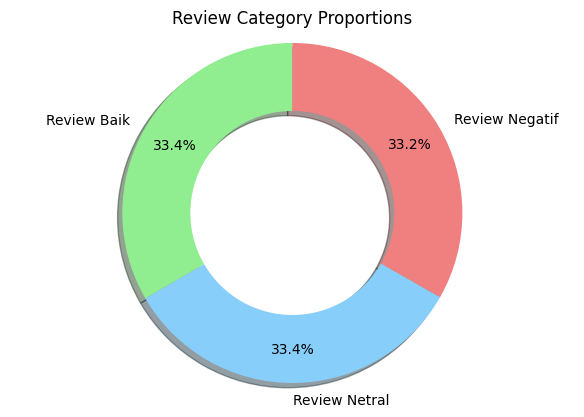

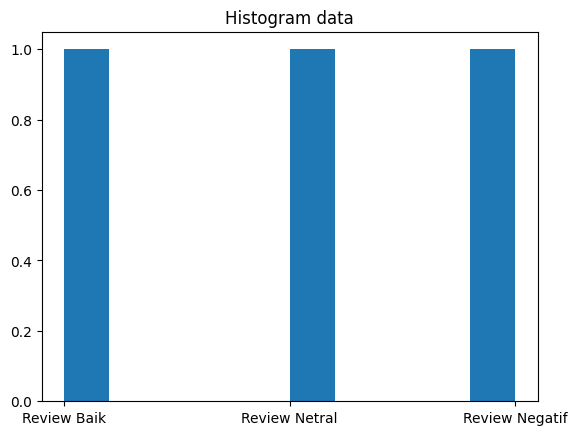

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()
plt.hist(labels,align='mid')
plt.title("Histogram data")
plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [ ]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [ ]:
import string

In [ ]:
def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus url
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)

  text = text.translate(str.maketrans("","",string.punctuation))

  return text

In [ ]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(clean_review)

  # delete empty row
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

In [ ]:
df_v1 = preprocess_v1(df)

In [ ]:

df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)

## Preprocessing Tahap 2

In [ ]:
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, sep='\r', names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")

In [ ]:
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

In [ ]:
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [ ]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(normalize_review)

  # delete empty row
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

In [ ]:
# take a while
df_v2  = preprocess_v2(df_v1)

In [ ]:
# export to tsv
df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [ ]:
def make_corpus(column):

    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [ ]:
# Takes a while
corpus = make_corpus(df_v2.review_text)

In [ ]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 4542


In [ ]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [ ]:
corpus_freq = word_freq(corpus, top=20)

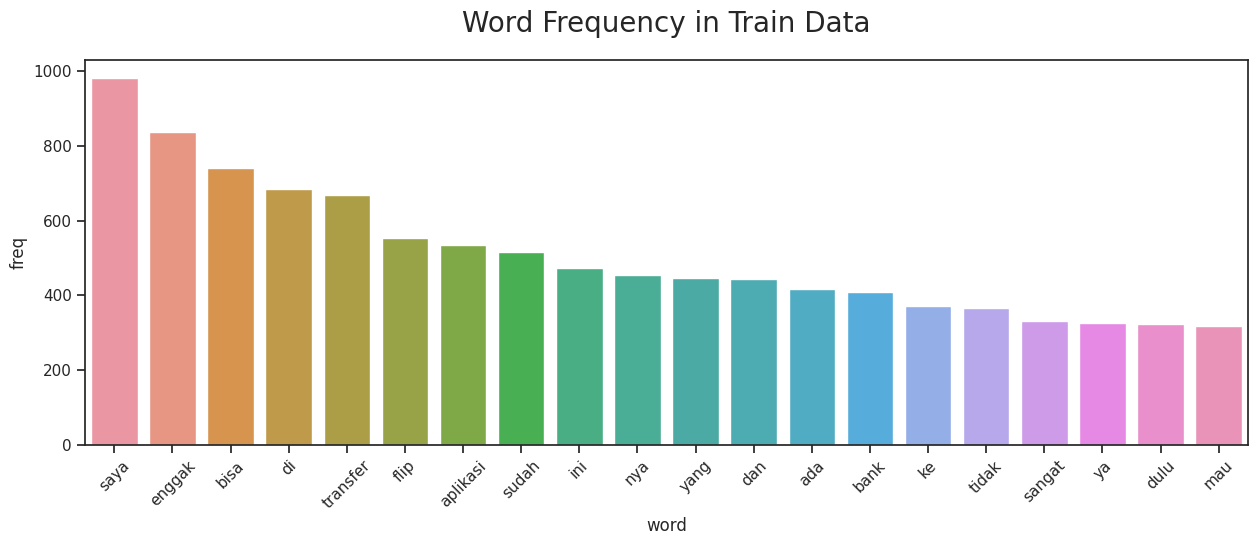

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

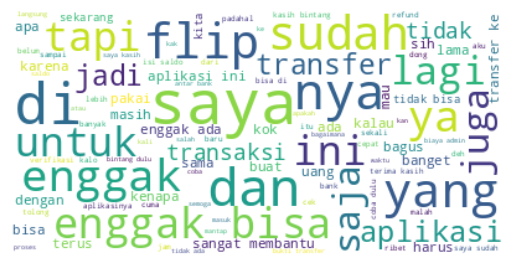

In [ ]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [ ]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

In [ ]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (2386, 2)
Val shape: (399, 2)
Test shape: (198, 2)


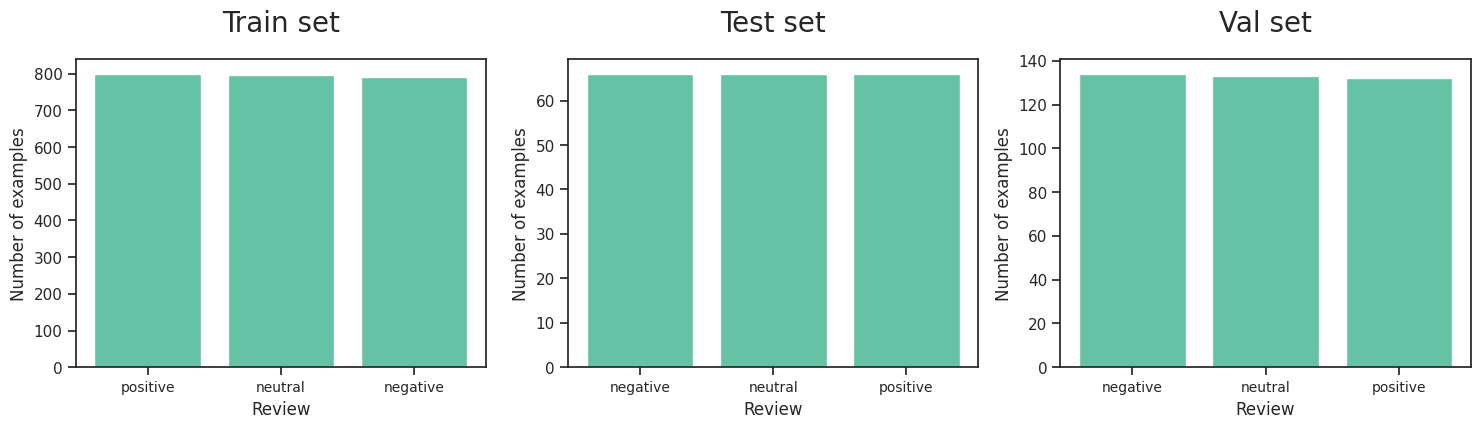

In [ ]:

fig = plt.figure(figsize=(18,4))
titles = ['Train set','Test set','Val set']
for i,dataf in enumerate([train_set,test_set,val_set]):
    ax = fig.add_subplot(1,3,i+1)
    Y, labels = pd.factorize(dataf['category'])
    ax.bar(labels, height=pd.Series(Y).value_counts())
    ax.set_xticks(ticks=range(len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    ax.set_xlabel('Review')
    ax.set_ylabel('Number of examples')
    ax.set_title(titles[i])

In [ ]:
# export to tsv
train_set.to_csv('/content/drive/My Drive/train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('/content/drive/My Drive/val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('/content/drive/My Drive/test_set.tsv', sep='\t', header=None, index=False)

# #saving to drive

# train_set.to_csv('/content/drive/My Drive/train_set.csv', index=False)
# val_set.to_csv('/content/drive/My Drive/val_set.csv', index=False)
# test_set.to_csv('/content/drive/My Drive/test_set.csv', index=False)

# 5. Modeling

## a. Finetuning IndoBERT

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

## b. Load Model

In [ ]:
from transformers import pipeline

pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = RobertaTokenizer.from_pretrained('w11wo/indonesian-roberta-base-sentiment-classifier')
config = RobertaConfig.from_pretrained('w11wo/indonesian-roberta-base-sentiment-classifier')
model = RobertaForSequenceClassification.from_pretrained('w11wo/indonesian-roberta-base-sentiment-classifier', config=config )
config.num_labels = DocumentSentimentDataset.NUM_LABELS
config.add_cross_attention
print(model.config)
# nlp = pipeline(
#     "sentiment-analysis",
#     model=pretrained_name,
#     tokenizer=pretrained_name
# )

# nlp("Jangan sampai saya telpon bos saya ya!")

model

RobertaConfig {
  "_name_or_path": "w11wo/indonesian-roberta-base-sentiment-classifier",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "neutral",
    "2": "negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 2,
    "neutral": 1,
    "positive": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.30.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
print(model.config)

RobertaConfig {
  "_name_or_path": "w11wo/indonesian-roberta-base-sentiment-classifier",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "neutral",
    "2": "negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 2,
    "neutral": 1,
    "positive": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.30.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [ ]:
# dropout_rate = 0.2
# for name, module in model.named_modules():
#     if isinstance(module, torch.nn.Dropout):
#         module.p = dropout_rate

# Setting PerEmbedding
# dropout_rate_embedding = 0.1
# dropout_rate_hidden = 0.1
# dropout_rate_attention = 0.1

# config.hidden_dropout_prob = dropout_rate_hidden
# config.attention_probs_dropout_prob = dropout_rate_attention
# config.hidden_dropout_prob = dropout_rate_hidden




RobertaConfig {
  "_name_or_path": "w11wo/indonesian-roberta-base-sentiment-classifier",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "neutral",
    "2": "negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 2,
    "neutral": 1,
    "positive": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.30.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [ ]:
# Struktur model
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
count_param(model)

124647939

## c. Prepare Dataset

In [ ]:
train_dataset_path = '/content/drive/My Drive/train_set.tsv'
valid_dataset_path = '/content/drive/My Drive/val_set.tsv'
test_dataset_path = '/content/drive/My Drive/test_set.tsv'

In [ ]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=64, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=64, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=64, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [ ]:
text = 'maksih grab udah ngnterin smpe tujuan dengan selmat dan aman'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: maksih grab udah ngnterin smpe tujuan dengan selmat dan aman | Label : positive (98.906%)


In [ ]:
text = 'masa tidak bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: masa tidak bisa transfer antar bank | Label : neutral (50.463%)


In [ ]:
text = 'bisa transfer antar bank gak?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank gak? | Label : neutral (96.342%)


## e. Fine Tuning & Prediksi Evaluation

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-6)
model = model.cuda()

RuntimeError: ignored

### Training

In [ ]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []
    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])
    history['train_loss'].append(tr_loss)

    # history['train_loss'].append(metrics['total_train_loss'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])
    history['val_loss'].append(valid_loss)

### Learning Curve

In [ ]:
#save model
model_save_name = 'classifier1robertafinetuned1e5ep63000.pt'
path = F'/content/drive/MyDrive/Model TA/{model_save_name}'
torch.save(model.state_dict(), path)

In [ ]:
plt.plot(history['val_loss'], label='valid loss')
plt.plot(history['train_loss'], label='train loss')
plt.title('Training history Loss')
plt.ylabel('LOSS')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)
val_df.head(10)

In [ ]:
val_df

## f. Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [ ]:
text = 'tidak bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

In [ ]:
text = 'bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

In [ ]:
text = 'bisa transfer antar bank?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

# 6. Evaluasi

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification , RobertaForSequenceClassification , RobertaTokenizer , BertForSequenceClassification , BertTokenizer

model1_name = 'w11wo/indonesian-roberta-base-sentiment-classifier'
pt1_name = RobertaForSequenceClassification.from_pretrained(model1_name)


model2_name = 'indobenchmark/indobert-base-p1'
pt2_name = BertForSequenceClassification.from_pretrained(model2_name)




In [ ]:

sentence2 = 'lumayan bisa transfer antar bank'

tokenizer1 =RobertaTokenizer.from_pretrained(model1_name)
tokenizer2 =BertTokenizer.from_pretrained(model2_name)
inputs4 = tokenizer2(sentence2)
inputs5 = tokenizer1(sentence2)
inputs4,inputs5


In [ ]:
tokenizer1.convert_ids_to_tokens([9199, 2508, 383, 4714, 2493, 2512]),tokenizer2.convert_ids_to_tokens([4942, 166, 4241, 2563, 1117])

In [ ]:
tokenizer2.convert_ids_to_tokens([2138, 4076, 469, 4266, 57, 1057])

In [ ]:
##training sessiong